In [1]:
import tensorflow as tf
from tensorflow.keras import Model, layers, datasets
tf.compat.v1.enable_eager_execution()
tf.print(tf. __version__)
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

2.8.2


In [2]:
def load_db(path='mnist.npz', batch_size=64, shuffle=True, valid_ratio=0.2):
    (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data(path)
    x_train, x_test = np.array(x_train, np.float32) / 255., np.array(x_test, np.float32)/ 255
    x_train_sampler, x_valid_sampler, y_train_sampler, y_valid_sampler = train_test_split(x_train, y_train,
                                                                                          stratify=y_train, test_size=valid_ratio)
    x_train_sampler = layers.Normalization(mean=0.5, variance=0.5)(x_train_sampler)
    x_valid_sampler = layers.Normalization(mean=0.5, variance=0.5)(x_valid_sampler)
    x_test = layers.Normalization(mean=0.5, variance=0.5)(x_test)

    train_loader = tf.data.Dataset.from_tensor_slices((x_train_sampler, y_train_sampler)).batch(batch_size)
    valid_loader = tf.data.Dataset.from_tensor_slices((x_valid_sampler, y_valid_sampler)).batch(batch_size)
    test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

    if shuffle:
        train_loader = train_loader.shuffle(5000)
        valid_loader = valid_loader.shuffle(5000)
        test_loader = test_loader.shuffle(5000)

    image_size, n_classes, channels_in = 28, 10, 1
    return train_loader, valid_loader, test_loader, image_size, n_classes, channels_in

In [3]:
class CCP(Model):
    def __init__(self, hidden_size, image_size=28, channels_in=1, n_degree=4, bias=False, n_classes=10):
        super(CCP, self).__init__()
        self.image_size = image_size
        self.channels_in = channels_in
        self.hidden_size = hidden_size
        self.n_classes = n_classes
        self.n_degree = n_degree
        self.total_image_size = self.image_size * self.image_size * channels_in
        init_U = tf.keras.initializers.RandomUniform(minval=-1*np.sqrt(1/self.total_image_size),
                                                          maxval=np.sqrt(1/self.total_image_size))
        for i in range(1, self.n_degree + 1):
            setattr(self, 'U{}'.format(i), layers.Dense(self.hidden_size,
                                                        use_bias=bias,
                                                        kernel_initializer=init_U,
                                                        bias_initializer=init_U))
        init_C = tf.keras.initializers.RandomUniform(minval=-1*np.sqrt(1/self.hidden_size),
                                                          maxval=np.sqrt(1/self.hidden_size))
        self.C = layers.Dense(self.n_classes,use_bias=True,kernel_initializer=init_C,bias_initializer=init_C)

    def call(self, z):
        h = layers.Flatten(input_shape=(self.image_size, self.image_size,self.channels_in))(z)
        out = self.U1(h)
        for i in range(2, self.n_degree + 1):
            out = getattr(self, 'U{}'.format(i))(h) * out + out
        out = self.C(out)
        return out

train_loader, valid_loader, test_loader, image_size, n_classes, channels_in = load_db(batch_size=64)
# create the model.
net = CCP(16, image_size=image_size, n_classes=n_classes)
# # define the optimizer
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
# # aggregate losses and accuracy.
train_losses, acc_list = [], []
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [4]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def train(train_loader, net, optimizer, criterion, epoch,):
    """ Perform single epoch of the training."""
    for idx, data_dict in enumerate(train_loader):
        img = data_dict[0]
        label = data_dict[1]
        with tf.GradientTape() as tape:
            predictions = net(img, training=True)
            loss = criterion(label, predictions)
        gradients = tape.gradient(loss, net.trainable_variables)
        optimizer.apply_gradients(zip(gradients, net.trainable_variables))
        train_loss(loss)
        train_accuracy(label, predictions)
        if idx % 100 == 0 and idx > 0:
            m2 = ('Epoch: {}, Epoch iters: {} / {}\t'
                  'Loss: {:.04f}, Acc: {:.06f}')
            print(m2.format(epoch, idx, len(train_loader), float(train_loss.result()), train_accuracy.result()))
    return train_loss.result()

def test(test_loader):
    """ Perform testing, i.e. run net on test_loader data
      and return the accuracy. """
    for test_images, test_labels in test_loader:
        predictions = net(test_images, training=False)
        t_loss = criterion(test_labels, predictions)
        test_loss(t_loss)
        test_accuracy(test_labels, predictions)
    return test_accuracy.result()

acc = 0.
for epoch in range(0, 5):
    print('Epoch {} (previous validation accuracy: {:.03f})'.format(epoch, acc))
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    loss_tr = train(train_loader, net, opt, criterion, epoch)
    acc = test(test_loader)
    train_losses.append(loss_tr)
    acc_list.append(acc)

Epoch 0 (previous validation accuracy: 0.000)
Epoch: 0, Epoch iters: 100 / 750	Loss: 2.2229, Acc: 0.169090
Epoch: 0, Epoch iters: 200 / 750	Loss: 2.0040, Acc: 0.295787
Epoch: 0, Epoch iters: 300 / 750	Loss: 1.7247, Acc: 0.409209
Epoch: 0, Epoch iters: 400 / 750	Loss: 1.4857, Acc: 0.499532
Epoch: 0, Epoch iters: 500 / 750	Loss: 1.3121, Acc: 0.563529
Epoch: 0, Epoch iters: 600 / 750	Loss: 1.1836, Acc: 0.609011
Epoch: 0, Epoch iters: 700 / 750	Loss: 1.0909, Acc: 0.641829
Epoch 1 (previous validation accuracy: 0.865)
Epoch: 1, Epoch iters: 100 / 750	Loss: 0.4559, Acc: 0.867420
Epoch: 1, Epoch iters: 200 / 750	Loss: 0.4490, Acc: 0.868315
Epoch: 1, Epoch iters: 300 / 750	Loss: 0.4403, Acc: 0.869809
Epoch: 1, Epoch iters: 400 / 750	Loss: 0.4321, Acc: 0.871532
Epoch: 1, Epoch iters: 500 / 750	Loss: 0.4235, Acc: 0.873721
Epoch: 1, Epoch iters: 600 / 750	Loss: 0.4150, Acc: 0.876560
Epoch: 1, Epoch iters: 700 / 750	Loss: 0.4075, Acc: 0.878655
Epoch 2 (previous validation accuracy: 0.902)
Epoch: 2

Text(0.5, 1.0, 'Validation accuracy')

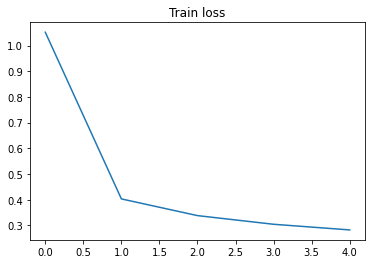

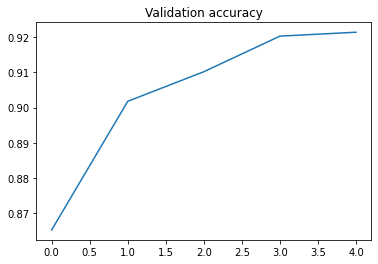

In [5]:
%matplotlib inline
plt.plot(train_losses)
plt.title('Train loss')
plt.figure()
plt.plot(acc_list)
plt.title('Validation accuracy')